##Kyle Braman, Donovan Dutcher, Nathaniel Plummer, William Bange

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the LDA items from scikit-learn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

from wordcloud import STOPWORDS

In [20]:
GTC_V2 = pd.read_csv('https://raw.githubusercontent.com/MiriamSchirmer/genocide-transcript-corpus/main/Dataset_GTC-V2.csv', sep =';')

In [21]:
ECCC = GTC_V2.loc[GTC_V2['tribunal']=="ECCC"] #Locate the ECCC tribunal in the GTC
ECCC2 = ECCC[['tribunal', 'accused', 'text', 'trauma', 'role']]
ECCC2_traum = ECCC2.loc[ECCC2['trauma']==1]

In [22]:
ECCC2_Kaing = ECCC2[ECCC2['role']=='Accused']
ECCC2_Kaing

,tribunal,accused,text,trauma,role
17053,ECCC,Kaing Guev Eav,"THE ACCUSED: Your Honours, first of all, let m...",0,Accused
17055,ECCC,Kaing Guev Eav,THE ACCUSED: I can state that Chan Voeun was n...,0,Accused
17056,ECCC,Kaing Guev Eav,"When Mr. Pon, Comrade Pon ask Comrade Meas how...",0,Accused
17057,ECCC,Kaing Guev Eav,In 1973 they did not yet assign the cooperativ...,0,Accused
17059,ECCC,Kaing Guev Eav,"THE ACCUSED: Your Honours, this person is not ...",0,Accused
...,...,...,...,...,...
32681,ECCC,Kaing Guev Eav,So these are my observations on the two separa...,0,Accused
32691,ECCC,Kaing Guev Eav,"THE ACCUSED: Your Honour, I do not object to t...",0,Accused
32694,ECCC,Kaing Guev Eav,THE ACCUSED: That's correct. Probably his mot...,0,Accused
32700,ECCC,Kaing Guev Eav,"THE ACCUSED: Mr. President, all evidence that ...",0,Accused


In [23]:
ECCC_Wit = ECCC2.loc[ECCC2['role']=='Witness']
ECCC_Wit

,tribunal,accused,text,trauma,role
16868,ECCC,Kaing Guev Eav,"MR. CHAN VOEUN: Yes, my name is Chan Voeun.",0,Witness
16870,ECCC,Kaing Guev Eav,MR. CHAN VOEUN: I am 56 years old.,0,Witness
16872,ECCC,Kaing Guev Eav,MR. CHAN VOEUN: I live in Amleang subdistrict.,0,Witness
16874,ECCC,Kaing Guev Eav,MR. CHAN VOEUN: I'm a farmer.,0,Witness
16876,ECCC,Kaing Guev Eav,MR. CHAN VOEUN: That is correct.,0,Witness
...,...,...,...,...,...
32724,ECCC,Kaing Guev Eav,A. He said the people who lived here had suffe...,0,Witness
32726,ECCC,Kaing Guev Eav,A. I remember that when I returned to Tuol Sle...,0,Witness
32728,ECCC,Kaing Guev Eav,A. The DC-Cam learned that I was the child sur...,0,Witness
32730,ECCC,Kaing Guev Eav,A. I cannot remember it but I probably do not ...,0,Witness


In [ ]:
text_pipeline = Pipeline([
     ('tokenize', CountVectorizer(max_features=1000, stop_words="english", ngram_range = (1,2))),
     ('tfidf', TfidfTransformer(use_idf=True)),
     ('lda', LatentDirichletAllocation(n_components=20))
    ]) #Construct a pipeline that performs tokenization removing stop words, TF-IDF transforms, and applies LDA

In [ ]:
np.random.seed(24601) #Randomize the seed

text_pipeline.fit_transform(ECCC["text"]); #Fit the pipeline to the text column

In [ ]:
word_list = text_pipeline["tokenize"].get_feature_names_out()
topic_num = 0 #Picking a topic number; Topics are assigned numbers by the code, we have to figure out what they are (not always easy)
num_words = 10 #Picking the number of words to see from that topic

df = pd.DataFrame({"words": word_list, "weights": text_pipeline["lda"].components_[topic_num]}) #Making all of this into a DataFrame

df.sort_values("weights", ascending=False).head(num_words)

,words,weights
994,yes,279.671769
569,mr,74.970275
459,koppe,63.025634
572,mr koppe,62.329244
926,true,34.295792
782,say,28.830645
594,nim,26.202375
237,did say,25.804443
575,mr president,22.900034
139,chan,22.617769


In [ ]:
def plot_top_words(pipeline, n_top_words=10, grid_shape=[5,5]):

    feature_names = pipeline["tokenize"].get_feature_names_out()
    model = pipeline["lda"]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.3, wspace=0.90, hspace=0.1)
    plt.show()

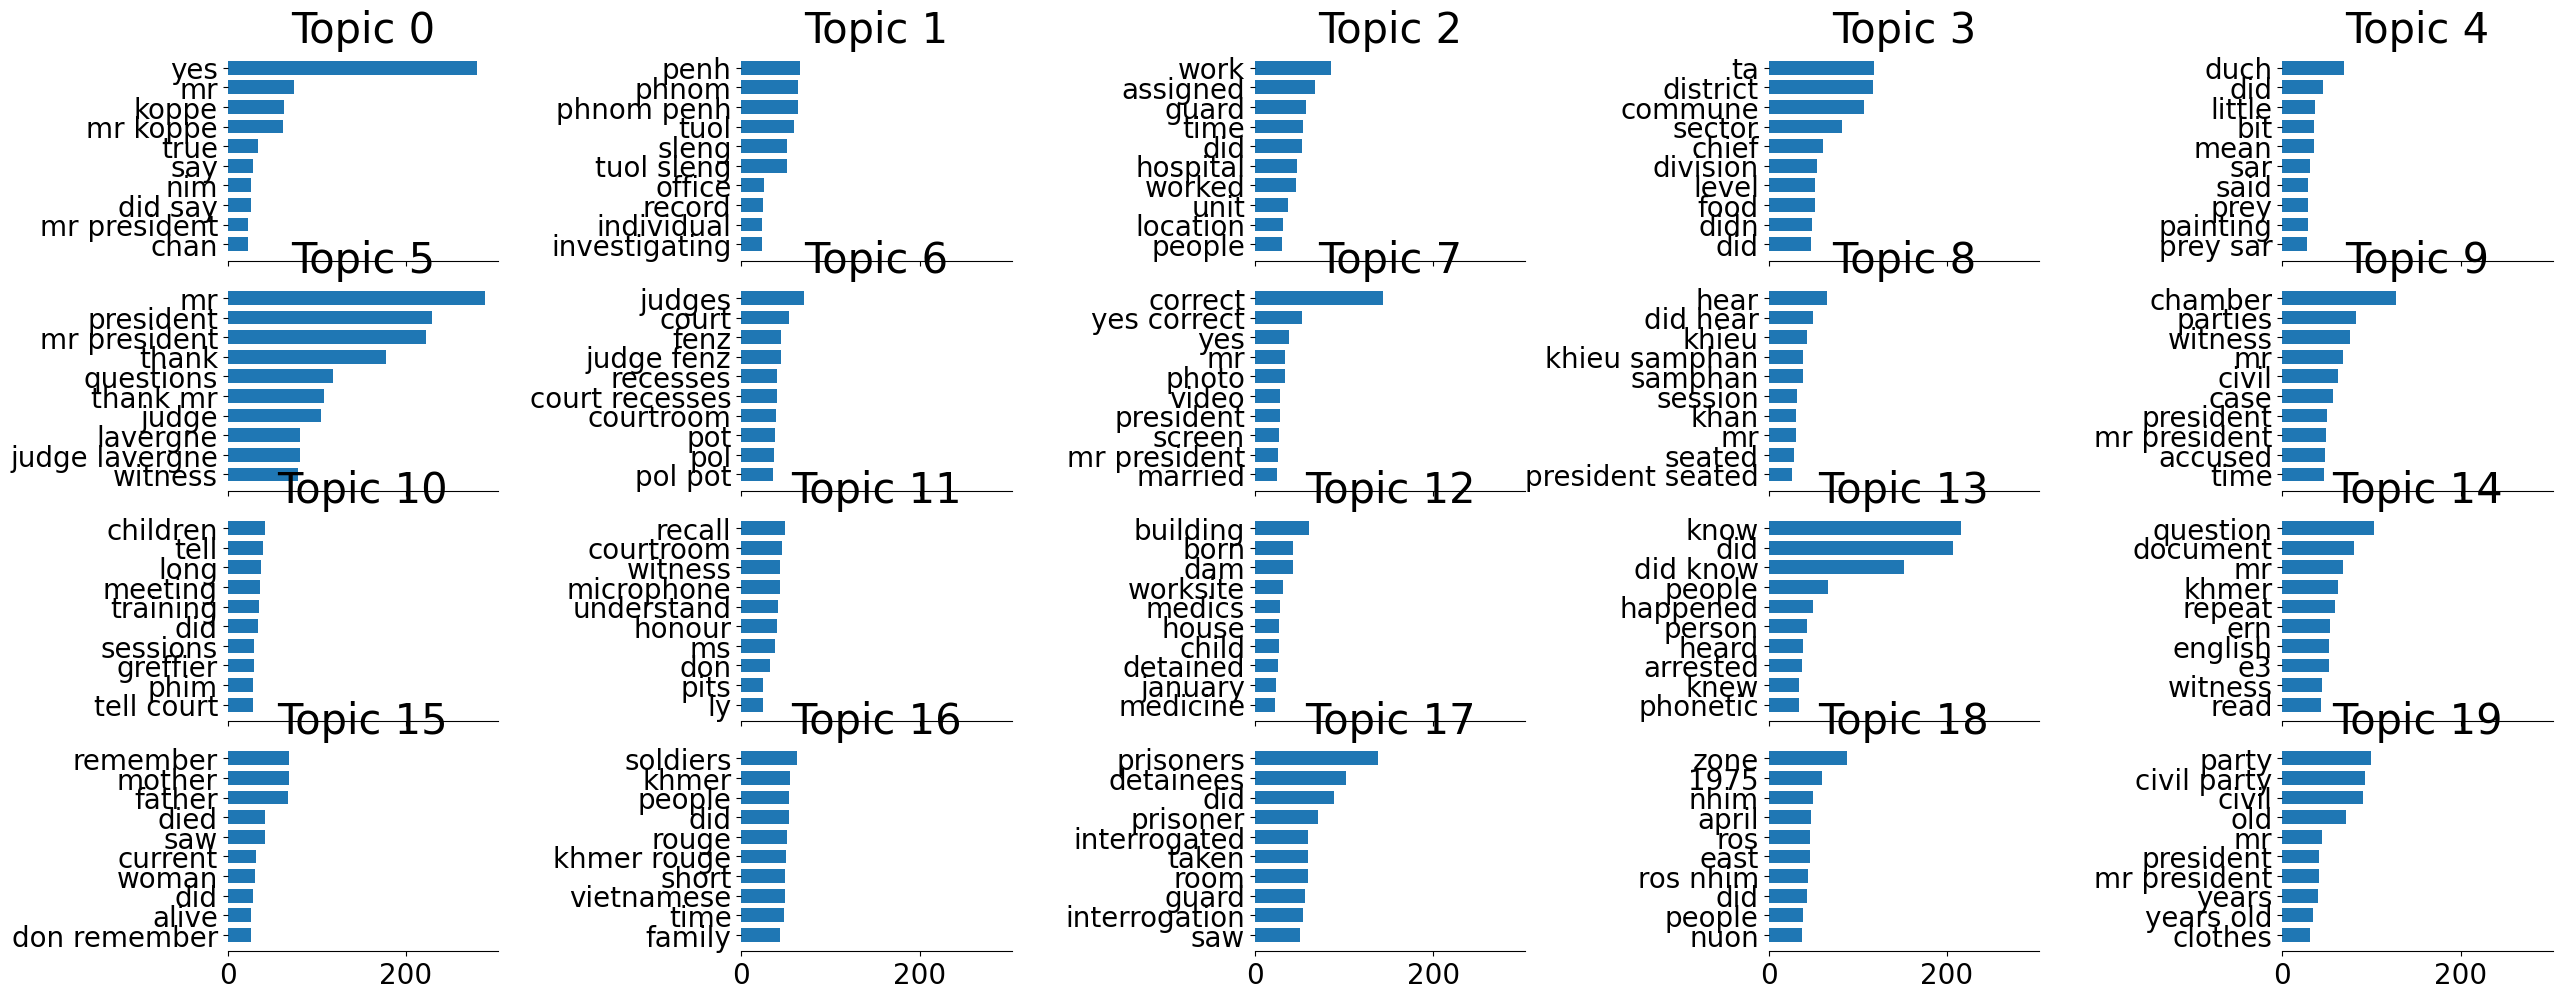

In [ ]:
plot_top_words(text_pipeline, 10, [4,5])